In [1]:
import numpy as np
import matplotlib.pyplot as plt
# to save and write as pngs
from imageio import imwrite, imread
import math

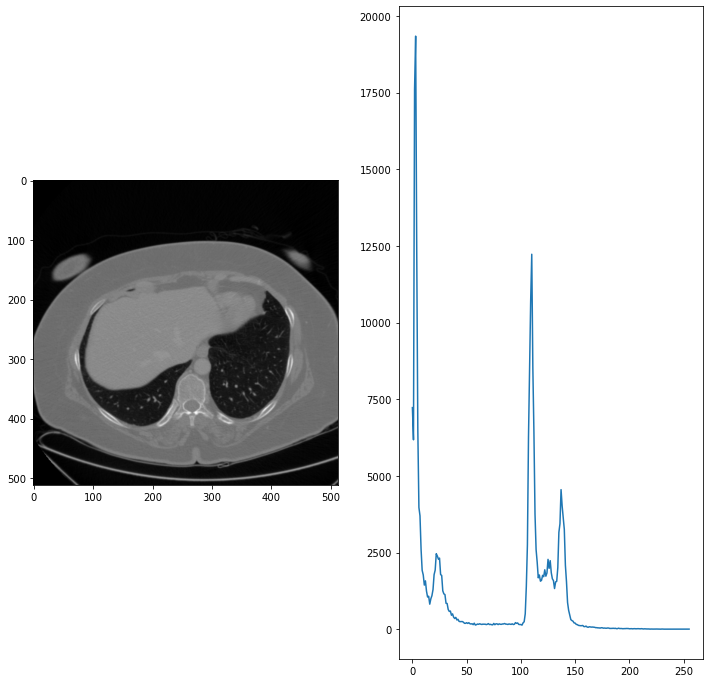

In [2]:
image = imread("testImagio_dicom.png")
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
uniqe = np.unique(image, return_counts=True)
plt.plot(uniqe[0],uniqe[1])
plt.show()


In [3]:
# normalize values
normalized_image = image / np.max(image)

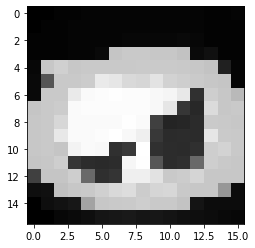

In [4]:
# Compress image by creating a new pixel by taking the median value from a square of 4x4 pixels
image_width = image.shape[0]

compression_factor = 32 # needs to be a multiple of 4 (e.g. 2,4,8,16)

new_width = int(image_width / compression_factor)

compressed_image = np.zeros((new_width,new_width))

for i in range(0, image_width, compression_factor):
    c_i = int(i / compression_factor)
    for j in range(0, image_width, compression_factor):
        c_j = int(j / compression_factor)
        pixels = normalized_image[i:i+compression_factor,j:j+compression_factor]
        compressed_image[c_i,c_j] = np.median(pixels)

plt.imshow(compressed_image, cmap='gray')

In [30]:
# similarity matrix - nodes are connected if they are neighbours and they share the same value
num_pixels = compressed_image.size

similarity_matrix = np.zeros((num_pixels,num_pixels),dtype=float)

compressed_image_width = compressed_image.shape[0]

max_distance = 5

sigma_distance = int(0.1 * compressed_image_width) # 10-20% of feature distance
sigma_intensity = 25 # 10-20% of feature distance (255)

for i in range(0,compressed_image_width):
    for j in range(0,compressed_image_width):
        sm_i = j + i * compressed_image_width
        for ii in range(0,compressed_image_width):
            for jj in range(0,compressed_image_width):
                sm_j = jj + ii * compressed_image_width

                distance = np.linalg.norm(np.array([i,j]) - np.array([ii,jj]))

                if distance > max_distance:
                    similarity_matrix[sm_i,sm_j] = 0
                else:
                    intensity_diff = np.linalg.norm(np.array(compressed_image[i,j]) - np.array(compressed_image[ii,jj]))
                    weight = np.exp(-np.power(intensity_diff,2)/sigma_intensity) * np.exp(-np.power(distance,2)/sigma_distance)
                    similarity_matrix[sm_i,sm_j] = weight


In [31]:

# debug purposes
np.savetxt("similarity.csv", similarity_matrix, fmt='%i', delimiter=",")
print(similarity_matrix)

[[1.         0.36787944 0.01831559 ... 0.         0.         0.        ]
 [0.36787944 1.         0.36787854 ... 0.         0.         0.        ]
 [0.01831559 0.36787854 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.36787854 0.01831554]
 [0.         0.         0.         ... 0.36787854 1.         0.36787921]
 [0.         0.         0.         ... 0.01831554 0.36787921 1.        ]]
